Problem1 : Implementation
============

/Users/jeongminlee/miniforge3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch : 0, train_loss : 6749.13525390625
epoch : 1, train_loss : 12.13845443725586
epoch : 2, train_loss : 2.8328027725219727
epoch : 3, train_loss : 2.8810219764709473
epoch : 4, train_loss : 2.8822426795959473
epoch : 5, train_loss : 2.8820888996124268
epoch : 6, train_loss : 2.881908416748047
epoch : 7, train_loss : 2.8817362785339355
epoch : 8, train_loss : 2.88157320022583
epoch : 9, train_loss : 2.881415605545044
epoch : 10, train_loss : 2.88126540184021
epoch : 11, train_loss : 2.881120204925537
epoch : 12, train_loss : 2.880981206893921
epoch : 13, train_loss : 2.880845546722412
epoch : 14, train_loss : 2.8807146549224854
epoch : 15, train_loss : 2.8805861473083496
epoch : 16, train_loss : 2.880462169647217
epoch : 17, train_loss : 2.880340576171875
epoch : 18, train_loss : 2.8802220821380615
epoch : 19, train_loss : 2.880105972290039
epoch : 20, train_loss : 2.8799915313720703
epoch : 21, train_loss : 2.8798789978027344
epoch : 22, train_loss : 2.8797690868377686
epoch : 23, t

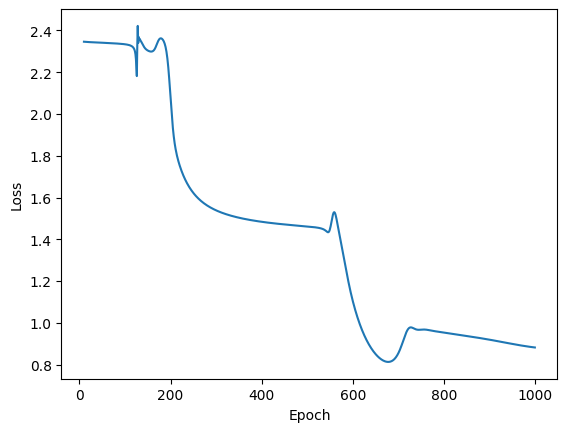

Test Loss : 1.2830710411071777, Accurarcy : 0.5196078431372549


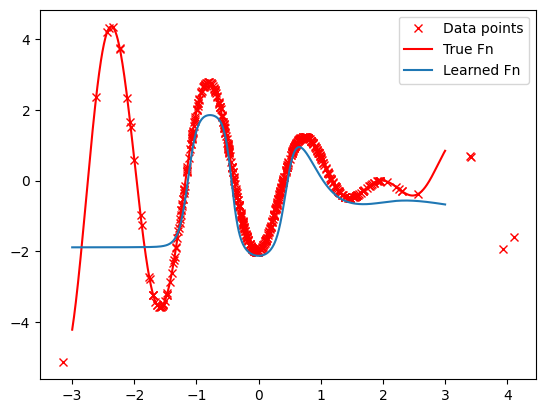

'\nWhen plotting torch tensors, you want to work with the\ntorch.no_grad() context manager.\n\nWhen you call plt.plot(...) the torch tensors are first converted into\nnumpy arrays and then the plotting proceeds.\nHowever, our trainable model has requires_grad=True to allow automatic\ngradient computation via backprop, and this option prevents \nconverting the torch tensor output by the model to a numpy array.\nUsing the torch.no_grad() context manager resolves this problem\nas all tensors are set to requires_grad=False within the context manager.\n\nAn alternative to using the context manager is to do \nplt.plot(xx, model(xx).detach().clone())\nThe .detach().clone() operation create a copied pytorch tensor that\nhas requires_grad=False.\n\nTo be more precise, .detach() creates another tensor with requires_grad=False\n(it is detached from the computation graph) but this tensor shares the same\nunderlying data with the original tensor. Therefore, this is not a genuine\ncopy (not a deep c

In [6]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

alpha = 0.1
K = 1000
B = 128
N = 512

def f_true(x) :
    return (x-2) * np.cos(x*4)

torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

'''
unsqueeze(1) reshapes the data into dimension [N,1],
where is 1 the dimension of an data point.

The batchsize of the test dataloader should not affect the test result
so setting batch_size=N may simplify your code.
In practice, however, the batchsize for the training dataloader
is usually chosen to be as large as possible while not exceeding
the memory size of the GPU. In such cases, it is not possible to
use a larger batchsize for the test dataloader.
'''

class MLP(nn.Module):
    def __init__(self, input_dim=1) :
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64, bias=True)
        self.linear2 = nn.Linear(64, 64, bias=True)
        self.linear3 = nn.Linear(64, 1 , bias=True)
        
    def forward(self, x) :
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
        
model = MLP()

model.linear1.weight.data = torch.normal (0 , 1 , model.linear1.weight.shape)
model.linear1.bias.data = torch.full(model.linear1.bias.shape, 0.03)

model.linear2.weight.data = torch.normal (0 , 1 , model.linear2.weight.shape)
model.linear2.bias.data = torch.full(model.linear2.bias.shape, 0.03)

model.linear3.weight.data = torch.normal (0 , 1 , model.linear3.weight.shape)
model.linear3.bias.data = torch.full(model.linear3.bias.shape, 0.03)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

losses = []

for epoch in range(K):
    tmp_losses = []
    for batch in train_dataloader: 
        optimizer.zero_grad()
        train_losses = 0

        input_batch = batch[0]
        label_batch = batch[1]

        perm = np.random.permutation(np.arange(B)) 
        for i in range(B):
            idx = perm[i%B]
            input = input_batch[idx]
            label = label_batch[idx]
            output = model(input)
            loss = criterion(output, label.unsqueeze(-1)) # Ensure dimensions are the same
            train_losses += loss

        train_losses = train_losses/B
        tmp_losses.append(train_losses)
        # losses.append(train_losses)
        train_losses.requires_grad_(True)
        train_losses.backward()
        optimizer.step()

    losses.append(np.mean([x.detach().numpy()  for x in tmp_losses]))
    print(f"epoch : {epoch}, train_loss : {torch.mean(torch.FloatTensor(train_losses))}")

with torch.no_grad():
    plt.figure()
    # plt.plot(range(10,N//B*K), losses[10:], label = "Train")
    plt.plot(range(10,K), losses[10:], label = "Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

plt.show()

losses = []
model.eval
N = X_val.shape[0]
test_losses = 0
hit = 0

for i in range(N):
    input = X_val[i].unsqueeze(-1)
    label = y_val[i]
    output = model(input)
    if np.abs(label.detach().numpy() - output.detach().numpy())<5e-1:
        hit +=1
    loss = criterion(output, label.unsqueeze(-1))
    test_losses += loss
test_losses = test_losses/N
accuracy = hit/N
print(f"Test Loss : {test_losses}, Accurarcy : {accuracy}")



with torch.no_grad():
    xx = torch.linspace(-3,3,1024).unsqueeze(1)
    plt.plot(X_train,y_train,'rx',label='Data points')
    # plt.plot(X_val, y_val, "bx",label = "test")
    plt.plot(xx,f_true(xx),'r',label='True Fn')
    plt.plot(xx, model(xx),label='Learned Fn')
plt.legend()
plt.show()

'''
When plotting torch tensors, you want to work with the
torch.no_grad() context manager.

When you call plt.plot(...) the torch tensors are first converted into
numpy arrays and then the plotting proceeds.
However, our trainable model has requires_grad=True to allow automatic
gradient computation via backprop, and this option prevents 
converting the torch tensor output by the model to a numpy array.
Using the torch.no_grad() context manager resolves this problem
as all tensors are set to requires_grad=False within the context manager.

An alternative to using the context manager is to do 
plt.plot(xx, model(xx).detach().clone())
The .detach().clone() operation create a copied pytorch tensor that
has requires_grad=False.

To be more precise, .detach() creates another tensor with requires_grad=False
(it is detached from the computation graph) but this tensor shares the same
underlying data with the original tensor. Therefore, this is not a genuine
copy (not a deep copy) and modifying the detached tensor will affect the 
original tensor is weird ways. The .clone() further proceeds to create a
genuine copy of the detached tensor, and one can freely manipulate and change it.
(For the purposes of plotting, it is fine to just call .detach() without
.clone() since plotting does not change the tensor.)

This discussion will likely not make sense to most students at this point of the course.
We will revisit this issue after we cover backpropagation.

'''


Problem2 : Implementation
============

/Users/jeongminlee/miniforge3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch : 0, train_loss : 1098.3204345703125
epoch : 1, train_loss : 2.9819936752319336
epoch : 2, train_loss : 2.982819080352783
epoch : 3, train_loss : 2.9820806980133057
epoch : 4, train_loss : 2.981334686279297
epoch : 5, train_loss : 2.980626106262207
epoch : 6, train_loss : 2.9799511432647705
epoch : 7, train_loss : 2.979304790496826
epoch : 8, train_loss : 2.9786806106567383
epoch : 9, train_loss : 2.978074789047241
epoch : 10, train_loss : 2.9774839878082275
epoch : 11, train_loss : 2.97690486907959
epoch : 12, train_loss : 2.976332664489746
epoch : 13, train_loss : 2.975764274597168
epoch : 14, train_loss : 2.9751994609832764
epoch : 15, train_loss : 2.9746317863464355
epoch : 16, train_loss : 2.974059581756592
epoch : 17, train_loss : 2.973479747772217
epoch : 18, train_loss : 2.972888946533203
epoch : 19, train_loss : 2.9722814559936523
epoch : 20, train_loss : 2.9716567993164062
epoch : 21, train_loss : 2.971008777618408
epoch : 22, train_loss : 2.9703314304351807
epoch : 23,

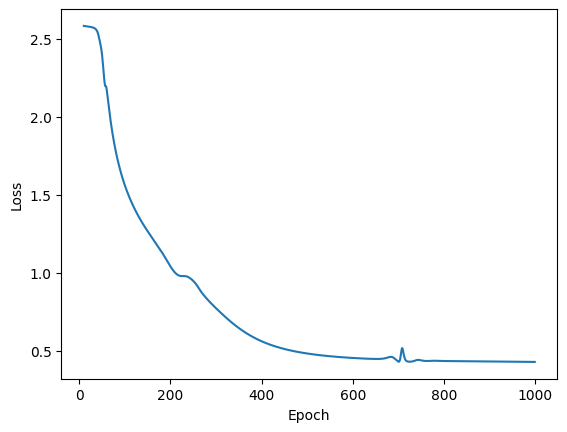

Test Loss : 0.15671254694461823, Accurarcy : 0.9313725490196079


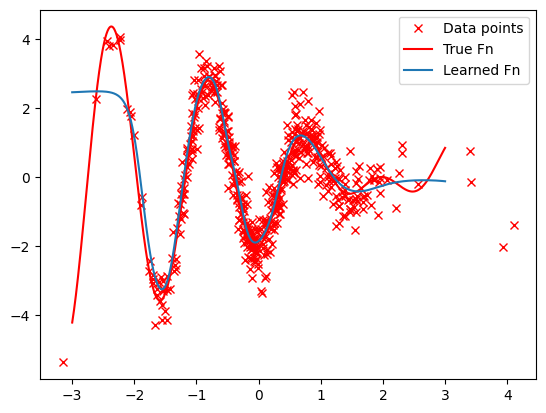

In [14]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

alpha = 0.1
K = 1000
B = 128
N = 512

def f_true(x) :
    return (x-2) * np.cos(x*4)

torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)  + torch.normal(0,0.5, X_train.shape)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)


class MLP(nn.Module):
    def __init__(self, input_dim=1) :
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64, bias=True)
        self.linear2 = nn.Linear(64, 64, bias=True)
        self.linear3 = nn.Linear(64, 1 , bias=True)
        
    def forward(self, x) :
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
        
model = MLP()

model.linear1.weight.data = torch.normal (0 , 1 , model.linear1.weight.shape)
model.linear1.bias.data = torch.full(model.linear1.bias.shape, 0.03)

model.linear2.weight.data = torch.normal (0 , 1 , model.linear2.weight.shape)
model.linear2.bias.data = torch.full(model.linear2.bias.shape, 0.03)

model.linear3.weight.data = torch.normal (0 , 1 , model.linear3.weight.shape)
model.linear3.bias.data = torch.full(model.linear3.bias.shape, 0.03)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

losses = []

for epoch in range(K):
    tmp_losses = []
    for batch in train_dataloader: 
        optimizer.zero_grad()
        train_losses = 0

        input_batch = batch[0]
        label_batch = batch[1]

        perm = np.random.permutation(np.arange(B)) 
        for i in range(B):
            idx = perm[i%B]
            input = input_batch[idx]
            label = label_batch[idx]
            output = model(input)
            loss = criterion(output, label.unsqueeze(-1)) # Ensure dimensions are the same
            train_losses += loss

        train_losses = train_losses/B
        tmp_losses.append(train_losses)
        # losses.append(train_losses)
        train_losses.requires_grad_(True)
        train_losses.backward()
        optimizer.step()

    losses.append(np.mean([x.detach().numpy()  for x in tmp_losses]))
    print(f"epoch : {epoch}, train_loss : {torch.mean(torch.FloatTensor(train_losses))}")

with torch.no_grad():
    plt.figure()
    # plt.plot(range(10,N//B*K), losses[10:], label = "Train")
    plt.plot(range(10,K), losses[10:], label = "Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

plt.show()

losses = []
model.eval
N = X_val.shape[0]
test_losses = 0
hit = 0

for i in range(N):
    input = X_val[i].unsqueeze(-1)
    label = y_val[i]
    output = model(input)
    if np.abs(label.detach().numpy() - output.detach().numpy())<5e-1:
        hit +=1
    loss = criterion(output, label.unsqueeze(-1))
    test_losses += loss
test_losses = test_losses/N
accuracy = hit/N
print(f"Test Loss : {test_losses}, Accurarcy : {accuracy}")

with torch.no_grad():
    xx = torch.linspace(-3,3,1024).unsqueeze(1)
    plt.plot(X_train,y_train,'rx',label='Data points')
    # plt.plot(X_val, y_val, "bx",label = "test")
    plt.plot(xx,f_true(xx),'r',label='True Fn')
    plt.plot(xx, model(xx),label='Learned Fn')
plt.legend()
plt.show()


In [12]:
sum(p.numel() for p in model.parameters())

4353